In [1]:
import itertools
import datetime as dt

import numpy as np
import pandas as pd
from pandas.api.types import CategoricalDtype
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Noto Sans CJK JP'
import seaborn as sns
import tqdm

from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.ensemble import RandomForestRegressor

from statsmodels.tsa.arima_model import ARIMA

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from utils.scaler import STMatrixStandardScaler
from utils.helper import format_stmatrix, train_test_split, fix_seed, seed_worker
from encdec.dataset import STDataset
from encdec.trainer import Trainer
from logger import Logger
import config

In [2]:
device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=3)

## 前処理してデータセットを作成
- 渋滞量 -> フラグに変換
- 方向 -> 0/1に変換
    - 上り: 0, 下り: 1
- 四半期を数値化
- 使用しないカラムを落とす
    - 天気 + `index`, `data`, `road_code`, `jam_type`
- 速度の欠損を埋める
- OCC -> [0, 1]に変換
- 型変換
    - float64 -> float32
    - 区間の名前, コード, 県コード, 0/1系, カレンダーデータをcategoryデータに
    - degreeをint32

In [ ]:
# 道路名
# TARGET_ROAD='tateyama'
TARGET_ROAD='kannetsu'

# 交通量
PROCESSED_DATA_DIR = '../Input_processed_data'
TRAFFIC_DIR = f'{PROCESSED_DATA_DIR}/traffic'
TRAFFIC_CSV = f'{TRAFFIC_DIR}/{TARGET_ROAD}_20220621all-merged_filled_1h.csv'

In [ ]:
col_types = {'start_code': str, 'end_code': str, 'road_code': str, 'jam_type': str,}

df = pd.read_csv(TRAFFIC_CSV, parse_dates=True, index_col='datetime', dtype=col_types).reset_index()

In [ ]:
def linear_interpolate(df, col):
    '''
    dfのcolカラム内の欠損を区間ごとに線形補間する
    '''
    f = lambda g: g.interpolate(method='linear', axis=0)
    
    df.sort_values('datetime', inplace=True)
    df[col] = df.groupby(['start_code', 'end_code'])[col].apply(f)
    return df


def preprocess(df):
    # 「年」情報を入れる
    df['year'] = df['datetime'].dt.year
    # 渋滞フラグ 0/1
    df['jam_quantity'] = np.where(df['speed'] < 40, 1, 0)
    # 方向を数値化
    direction_map = {'上り': 0, '下り': 1}
    df['direction'] = df['direction'].map(direction_map)
    # 四半期を数値化
    df['quarter'] = df['quarter'].str[-1]
    
    # object型のカラム, いらないカラムを落とす
    drop_cols = [
        'index', 'date', 'road_code', 'pressure', 'rainfall', 
        'temperature', 'humidity', 'wind_speed', 'daylight_hours', 
        'snowfall', 'deepest_snowfall', 'weather_description', 'jam_type'
    ]
    df.drop(drop_cols, axis=1, inplace=True)
    
    # 速度の欠損を埋める
    df = linear_interpolate(df, 'speed')
    # OCCを[0,1]に変換
    df['OCC'] = df['OCC'] / 100.0
    
    # 型変換
    f64_cols = df.select_dtypes(include=[np.float64]).columns
    df.loc[:, f64_cols] = df.loc[:, f64_cols].astype(np.float32)
    i64_cols = df.select_dtypes(include=[int]).columns
    df.loc[:, i64_cols] = df.loc[:, i64_cols].astype(np.int32)
    
    type_map = {
        'start_name': 'category',
        'end_name': 'category',
        'start_code': 'category',
        'end_code': 'category',
        'start_pref_code': 'category',
        'end_pref_code': 'category',
        'direction': 'category',
        'month': 'category',
        'day': 'category',
        'dayofweek': 'category',
        'is_holiday': 'category',
        'hour': 'category',
        'quarter': 'category',
        'jam_quantity': 'category',
        'start_degree': np.int32,
        'end_degree': np.int32,
        'degree_sum': np.int32,
    }
    df = df.astype(type_map)
    
    return df

In [ ]:
def create_dataset(df, start_date, end_date, pkl_name):
    tmp = df.loc[(df['datetime'] >= pd.Timestamp(start_date)) & (df['datetime'] < pd.Timestamp(end_date))]
    # tmp.reset_index(drop=True, inplace=True)
    
    tmp = preprocess(tmp.copy())
    tmp.reset_index(drop=True, inplace=True)
    
    tmp.to_pickle(pkl_name)

# whole dataset
start_date = '2021/4/2'
end_date = '2022/6/1'
pkl_name = './datasets_1h/kannetsu_210402-220531.pkl'

create_dataset(df, start_date, end_date, pkl_name)

# mini dataset
start_date = '2021/4/2'
end_date = '2021/6/1'
pkl_name = './datasets_1h/kannetsu_210402-210531.pkl'

create_dataset(df, start_date, end_date, pkl_name)

## データセットを読み込む

In [ ]:
# mini
df_test = pd.read_pickle('./datasets_1h/kannetsu_210402-210531.pkl')
# whole
df_all = pd.read_pickle('./datasets_1h/kannetsu_210402-220531.pkl')

In [ ]:
dt_table = pd.read_pickle(f'{config.TABLES_DIR}/datetime_table.pkl')
sec_table = pd.read_pickle(f'{config.TABLES_DIR}/section_table.pkl')

In [ ]:
df_test.head(3)

### 時間, 区間にembedding用のIDを割り振る

In [ ]:
# 時間情報を管理するためのテーブルを作成 (month x hour x dayofweeks x is_holidays)
# months = range(1, 12+1)
# hours = range(24)
# dayofweeks = range(1, 7+1)
# is_holidays = (0, 1)

# dt_table = pd.DataFrame(itertools.product(months, hours, dayofweeks, is_holidays), columns=['month', 'hour', 'dayofweek', 'is_holiday'], dtype='category')
# dt_table = dt_table.query('dayofweek not in (6, 7) | is_holiday != 0').reset_index(drop=True)
# dt_table = dt_table.reset_index().set_index(['month', 'hour', 'dayofweek', 'is_holiday']).astype('category')

# dt_table.to_pickle('./datasets/datetime_table.pkl')

# dt_table = pd.read_pickle('./datasets/datetime_table.pkl')

In [ ]:
# 時間情報を管理するためのテーブルを作成 (hour x dayofweeks x is_holidays)
# hours = range(24)
# dayofweeks = range(1, 7+1)
# is_holidays = (0, 1)

# dt_table = pd.DataFrame(itertools.product(hours, dayofweeks, is_holidays), columns=['hour', 'dayofweek', 'is_holiday'], dtype='category')
# dt_table = dt_table.query('dayofweek not in (6, 7) | is_holiday != 0').reset_index(drop=True)
# dt_table = dt_table.reset_index().set_index(['hour', 'dayofweek', 'is_holiday']).astype('category')

# dt_table.to_pickle('./datasets/mini_datetime_table.pkl')

# dt_table = pd.read_pickle('./datasets/mini_datetime_table.pkl')

In [ ]:
# 区間情報を管理するためのテーブルを作成
# sec_table = df_test[['start_name', 'end_name', 'direction', 'KP']].drop_duplicates()
# 区間順にソート
# sort_f = lambda g: g.sort_values('KP', ascending=(g.name == 1))
# sec_table = sec_table.groupby('direction').apply(sort_f).reset_index(drop=True)

# sec_table.to_pickle('./datasets/section_table.pkl')
# sec_table.head(3)

# sec_table = pd.read_pickle('./datasets/section_table.pkl')

In [ ]:
def datetime2id(df, dt_table):
    time_col = ['hour', 'dayofweek', 'is_holiday']
    f = lambda g: g.assign(datetime_id=dt_table.loc[g.name, 'index'])
    df = df.groupby(time_col).apply(f)
    df['datetime_id'] = df['datetime_id'].astype('category')
    return df


def section2id(df, sec_table):
    f = lambda g: g.assign(section_id=sec_table.query(f'start_name == "{g.name[0]}" & end_name == "{g.name[1]}"').index.item())
    df = df.groupby(['start_name', 'end_name']).apply(f)
    df['section_id'] = df['section_id'].astype('category')
    return df


def identify(df, dt_table, sec_table):
    df = datetime2id(df, dt_table)
    df = section2id(df, sec_table)
    return df

In [ ]:
df_test = identify(df_test, dt_table, sec_table)
df_test.to_pickle('./datasets_1h/kannetsu_210402-210531.pkl')

df_all = identify(df_all, dt_table, sec_table)
df_all.to_pickle('./datasets_1h/kannetsu_210402-220531.pkl')

## Train, Testに分割

In [ ]:
# train: 2021/4/2 - 2022/2/28
# test: 2022/3/1 - 2022/5/31
df_all = pd.read_pickle('./datasets_1h/kannetsu_210402-220531.pkl')

sep_date = '2022/3/1'
df_train = df_all.loc[df_all['datetime'] < pd.Timestamp(sep_date)]
df_test = df_all.loc[df_all['datetime'] >= pd.Timestamp(sep_date)]

df_train.to_pickle('./datasets_1h/kannetsu_210402-220228.pkl')
df_test.to_pickle('./datasets_1h/kannetsu_220301-220531.pkl')

In [ ]:
# train: 2021/4/2 - 2021/5/19
# test: 2021/5/20 - 2021/5/31
df_mini = pd.read_pickle('./datasets_1h/kannetsu_210402-210531.pkl')

sep_date = '2021/5/20'
df_train = df_mini.loc[df_mini['datetime'] < pd.Timestamp(sep_date)]
df_test = df_mini.loc[df_mini['datetime'] >= pd.Timestamp(sep_date)]

df_train.to_pickle('./datasets_1h/kannetsu_210402-210519.pkl')
df_test.to_pickle('./datasets_1h/kannetsu_210520-210531.pkl')

## Spatial Temporal Matrixに整形
- 区間数 x 時系列数 の行列
- 実際は 区間数 x 時系列数 x 特徴量数 のテンソル

In [ ]:
df_test_tr = pd.read_pickle('./datasets_1h/kannetsu_210402-210519.pkl')
df_test_va = pd.read_pickle('./datasets_1h/kannetsu_210520-210531.pkl')

df_all_tr = pd.read_pickle('./datasets_1h/kannetsu_210402-220228.pkl')
df_all_va = pd.read_pickle('./datasets_1h/kannetsu_220301-220531.pkl')

dt_table = pd.read_pickle(f'{config.TABLES_DIR}/datetime_table.pkl')
sec_table = pd.read_pickle(f'{config.TABLES_DIR}/section_table.pkl')

In [ ]:
# 特徴量の元になる列
# time_col = ['month', 'hour', 'dayofweek', 'is_holiday']
# section_col = ['direction', 'lane_count', 'KP']
time_col = ['datetime_id']
section_col = ['section_id']
search_col = ['search_1h', 'search_unspec_1d']
traffic_col = ['allCars']

feature_col = time_col + section_col + search_col + traffic_col
# feature_col = time_col + section_col + traffic_col
# feature_col = search_col + traffic_col

# 予測対象
target_col = 'allCars'

In [ ]:
X_tr, y_tr = format_stmatrix(df_all_tr, sec_table, feature_col, config.TARGET_COL)
X_va, y_va = format_stmatrix(df_all_va, sec_table, feature_col, config.TARGET_COL)
print(X_tr.shape, X_va.shape, y_tr.shape, y_va.shape)

In [ ]:
# torch.save(X_tr, './datasets_1h/features_train.pkl')
# torch.save(X_va, './datasets_1h/features_test.pkl')
# torch.save(y_tr, './datasets_1h/labels_train.pkl')
# torch.save(y_va, './datasets_1h/labels_test.pkl')

# torch.save(X_tr, f'datasets_1h/mini_features_train.pkl')
# torch.save(X_va, f'datasets_1h/mini_features_test.pkl')
# torch.save(y_tr, f'datasets_1h/mini_labels_train.pkl')
# torch.save(y_va, f'datasets_1h/mini_labels_test.pkl')

## 標準化・正規化
- 標準化を行う
- 時間特徴量（`month`, `hour`, `day_of_week`）はsin, cosで変換するのもやってみる
- 検索数, 台数は上り・下り別でもやってみる

In [ ]:
dt_table = pd.read_pickle(f'{config.TABLES_DIR}/datetime_table.pkl')
sec_table = pd.read_pickle(f'{config.TABLES_DIR}/section_table.pkl')

X_tr = torch.load('./datasets_1h/features_train.pkl')
X_va = torch.load('./datasets_1h/features_test.pkl')
y_tr = torch.load('./datasets_1h/labels_train.pkl')
y_va = torch.load('./datasets_1h/labels_test.pkl')

# X_tr = torch.load(f'datasets_1h/mini_features_train.pkl')
# X_va = torch.load(f'datasets_1h/mini_features_test.pkl')
# y_tr = torch.load(f'datasets_1h/mini_labels_train.pkl')
# y_va = torch.load(f'datasets_1h/mini_labels_test.pkl')

print(X_tr.shape, X_va.shape)
print(y_tr.shape, y_va.shape)

In [ ]:
# ID列は飛ばして標準化
skip_features = [0, 1]
scaler = STMatrixStandardScaler(skip_features=skip_features)

scaler.fit(X_tr)
X_tr_norm = scaler.transform(X_tr)

scaler.fit(X_va)
X_va_norm = scaler.transform(X_va)

# torch.save(X_tr_norm, f'datasets_1h/features_train_norm.pkl')
# torch.save(X_va_norm, f'datasets_1h/features_test_norm.pkl')

## データセットの定義

In [2]:
dt_table = pd.read_pickle(f'{config.TABLES_DIR}/datetime_table.pkl')
sec_table = pd.read_pickle(f'{config.TABLES_DIR}/section_table.pkl')

X_tr = torch.load(f'{config.DATASET_DIR}_1h/features_train_norm.pkl')
X_va = torch.load(f'{config.DATASET_DIR}_1h/features_test_norm.pkl')
y_tr = torch.load(f'{config.DATASET_DIR}_1h/labels_train.pkl')
y_va = torch.load(f'{config.DATASET_DIR}_1h/labels_test.pkl')

# X_tr = torch.load(f'datasets_1h/mini_features_train_norm.pkl')
# X_va = torch.load(f'datasets_1h/mini_features_test_norm.pkl')
# y_tr = torch.load(f'datasets_1h/mini_labels_train.pkl')
# y_va = torch.load(f'datasets_1h/mini_labels_test.pkl')

print(dt_table.shape, sec_table.shape)
print(X_tr.shape, X_va.shape)
print(y_tr.shape, y_va.shape)

(288, 1) (63, 4)
torch.Size([5, 7992, 63]) torch.Size([5, 2208, 63])
torch.Size([1, 7992, 63]) torch.Size([1, 2208, 63])


In [4]:
time_step = 7 * 24
space_window = None

dataset_train = STDataset(X_tr, y_tr, 
                          time_step=time_step, 
                          space_window=space_window)

dataset_valid = STDataset(X_va, y_va, 
                          time_step=time_step, 
                          space_window=space_window)

In [ ]:
def test_baseline(model, filter_num, testfilter_num):
    data, pathlist = dataloader.load_data_noneighbour(5, 5)

    traindata = data[:, :-config.valid_length // 2, 0]
    testdata = data[:, -config.valid_length:, 0]

    print("Get XY ...")
    x, y = get_xy(traindata, 1, filter_num)
    print("Get Train XY %s %s " % (x.shape, y.shape))
    tx, ty = get_xy(testdata, config.out_seq_length, testfilter_num)
    print("Get Test XY %s %s " % (tx.shape, ty.shape))
    ex, ey = get_xy(testdata, config.out_seq_length, testfilter_num, event=True)
    print("Get Etest XY %s %s " % (ex.shape, ey.shape))

    # x, y = sklearn.utils.shuffle(x, y)
    # x = x[:30000, :]
    # y = y[:30000]

    # tx, ty = sklearn.utils.shuffle(tx, ty)
    # tx = tx[:30000, :]
    # ty = ty[:30000]

    print("Train")
    stime = time.time()
    model.fit(x, y)
    etime = time.time()
    print("Train %d" % (etime - stime))

    def test(testx, testy):
        print("Test")
        stime = time.time()
        predlist = list()
        for pid in range(config.out_seq_length):
            print("Test %d %d" % (pid, time.time() - stime))
            pred = model.predict(testx)
            predlist.append(pred)
            testx[:, :-1] = testx[:, 1:]
            testx[:, -1] = pred
        etime = time.time()
        print("Test %d" % (etime - stime))

        predlist = np.stack(predlist, axis=-1)
        mapeloss = utils.mape(predlist, testy)
        tloss = np.mean(mapeloss, axis=0)
        print("Test ", tloss)

    test(tx, ty)
    test(ex, ey)
    # print(sumtloss / data.shape[0])

def test_arima(testfilter_num):
    data, pathlist = dataloader.load_data_noneighbour(5, 5)

    # traindata = data[:, :-config.valid_length // 2, 0]
    testdata = data[:, -config.valid_length:, 0]

    print("Get XY ...")
    # x, y = get_xy(traindata, 1, filter_num)
    # print("Get Train XY %s %s " % (x.shape, y.shape))
    tx, ty = get_xy(testdata, config.out_seq_length, testfilter_num)
    print("Get Test XY %s %s " % (tx.shape, ty.shape))
    ex, ey = get_xy(testdata, config.out_seq_length, testfilter_num, event=True)
    print("Get Etest XY %s %s " % (ex.shape, ey.shape))

    # x, y = sklearn.utils.shuffle(x, y)
    # x = x[:30000, :]
    # y = y[:30000]

    # tx, ty = sklearn.utils.shuffle(tx, ty)
    # tx = tx[:30000, :]
    # ty = ty[:30000]

    def test(testx, testy):
        print("Test")
        stime = time.time()
        predlist = list()
        for idx in range(testx.shape[0]):
            model = ARIMA(testx[0], order=(1, 1, 0))
            model_fit = model.fit(disp=0)
            pred, stderr, conf_int = model_fit.forecast(config.out_seq_length)
            predlist.append(pred)
            if idx % 20 == 0:
                print("Test %d %d" % (idx, time.time() - stime), utils.mape(pred, testy[idx]))

        etime = time.time()
        print("Test %d" % (etime - stime))
        predlist = np.stack(predlist, axis=0)
        mapeloss = utils.mape(predlist, testy)
        tloss = np.mean(mapeloss, axis=0)
        print("Test ", tloss)
        return tloss

    timeloss = test(tx, ty)
    eventloss = test(ex, ey)
    print(timeloss, np.mean(timeloss))
    print(eventloss, np.mean(eventloss))
    # print(sumtloss / data.shape[0])

## Networkの定義

In [5]:
TRAFFIC_CONV = 64
TRAFFIC_HIDDEN = 128
TRAFFIC_LSTM_LAYERS = 2
TRAFFIC_KERNEL = (7,5)

SEARCH_CONV = 64
SEARCH_HIDDEN = 128
SEARCH_LSTM_LAYERS = 2
SEARCH_KERNEL = (7,5)

UNSPEC_SEARCH_HIDDEN = 64
UNSPEC_SEARCH_KERNEL = 5

DATETIME_EMB = 32
ROAD_EMB = 16

FC_EMB = 32

### LSTM only EncDec

In [337]:
class LSTMEncoder(nn.Module):
    def __init__(self, bidirectional=True):
        super().__init__()
        
        self.bidirectional = bidirectional
        self.lstm = nn.LSTM(1, TRAFFIC_HIDDEN, TRAFFIC_LSTM_LAYERS, bidirectional=bidirectional, dropout=0.4, batch_first=True)
    
    def forward(self, x):
        N, T, S = x.shape
        x = x[..., [S // 2]]
        # N x T x 1 -> N x T x H, (L x N x H, L x N x H)
        outs, (h, c) = self.lstm(x)
        
        if self.bidirectional:
            # 2*L_t x N x H_t -> L_t x N x 2*H_t
            L2, N, H_t = h.shape
            h = h.transpose(0,1).reshape(N, L2 // 2, -1).transpose(0,1).contiguous()
            c = h.transpose(0,1).reshape(N, L2 // 2, -1).transpose(0,1).contiguous()    
        
        return outs, (h, c)
    

class LSTMDecoder(nn.Module):
    def __init__(self, bidirectional=True):
        super().__init__()
        
        self.dropout_ratio = 0.3
        
        self.hid_dim = 2 * TRAFFIC_HIDDEN if bidirectional else TRAFFIC_HIDDEN
        
        self.lstm = nn.LSTM(1, self.hid_dim, TRAFFIC_LSTM_LAYERS, dropout=self.dropout_ratio, batch_first=True)
        self.fc1 = nn.Linear(self.hid_dim, FC_EMB)
        self.fc2 = nn.Linear(FC_EMB, 1)

    def forward(self, x, state):
        N, _, P = x.shape
        
        # N x C=1 x P -> N x P x C=1
        x = x.permute(0, 2, 1)
        # N x P x C, (L x N x H_t, L x N x H_t) -> N x P x H_t, (L x N x H_t, L x N x H_t)
        outs, state = self.lstm(x, state)
        outs = F.relu(self.fc1(outs))
        outs = self.fc2(outs)

        return outs, state
    
    def generate(self, trf_enc, start_value=-1.0):
        with torch.no_grad():
            # N x 1 x 1
            N = trf_enc[0].shape[1]
            out = torch.tensor(start_value).repeat(N).unsqueeze(-1).unsqueeze(-1)
            out = out.to(trf_enc[0].device)
            
            state = trf_enc
            
            generated = []

            for i in range(24):
                out, state = self.forward(out, state)
                generated.append(out)
        
        # N x P x 1
        generated = torch.cat(generated, dim=1)
        # N x P x 1 -> N x P
        generated = generated[..., 0]
        return generated
    

class LSTMOnlyEncoderDecoder(nn.Module):
    def __init__(self, bidirectional=True):
        super().__init__()
        
        self.encoder = LSTMEncoder(bidirectional=bidirectional)
        self.decoder = LSTMDecoder(bidirectional=bidirectional)
        
    def forward(self, features, decoder_xs):
        dt, rd, sr, un_sr, trf = features
        
        outs_trf, state_trf = self.encoder(trf)
        outs, _ = self.decoder(decoder_xs, state_trf)

        return outs
    
    def generate(self, features, start_value=-1.0):
        dt, rd, sr, un_sr, trf = features
        
        outs_trf, state_trf = self.encoder(trf)    
        generated = self.decoder.generate(state_trf, start_value)
        return generated

In [338]:
(dt, rd, sr, un_sr, trf), labels = dataset_train[:16]
print(trf.shape, labels.shape)

torch.Size([16, 168, 5]) torch.Size([16, 1, 24])


In [341]:
(outs_trf, state_trf) = LSTMEncoder()(trf)
print(outs_trf.shape, state_trf[0].shape)

decoded, _ = LSTMDecoder()(labels, state_trf)
print(decoded.shape)

predicted = LSTMOnlyEncoderDecoder().generate((dt, rd, sr, un_sr, trf))
print(predicted.shape)

torch.Size([16, 168, 256]) torch.Size([2, 16, 256])
torch.Size([16, 24, 1])
torch.Size([16, 24])


In [342]:
features, labels = dataset_train[:16]

In [343]:
decoder_xs = torch.full_like(labels, -1)
decoder_xs[..., 1:] = labels[..., :-1]

In [344]:
out = LSTMOnlyEncoderDecoder()((dt, rd, sr, un_sr, trf), decoder_xs)
out.shape

torch.Size([16, 24, 1])

### LSTM + CNN EncDec

In [348]:
class CNNLSTMEncoder(nn.Module):
    def __init__(self, bidirectional=True):
        super().__init__()
        
        self.bidirectional = bidirectional
        
        self.conv = nn.Conv2d(1, TRAFFIC_CONV, TRAFFIC_KERNEL, padding=(TRAFFIC_KERNEL[0]//2, 0), padding_mode='replicate')
        self.lstm = nn.LSTM(TRAFFIC_CONV, TRAFFIC_HIDDEN, TRAFFIC_LSTM_LAYERS, bidirectional=bidirectional, dropout=0.4, batch_first=True)
    
    def forward(self, x):
        N, T, S = x.shape
        
        out = F.relu(self.conv(x.unsqueeze(1)))
        # N x C x T -> N x T x C
        out = out[..., 0].permute(0, 2, 1)
        # N x T x C -> N x T x H, (L x N x H, L x N x H)
        outs, (h, c) = self.lstm(out)
        
        if self.bidirectional:
            # 2*L_t x N x H_t -> L_t x N x 2*H_t
            L2, N, H_t = h.shape
            h = h.transpose(0,1).reshape(N, L2 // 2, -1).transpose(0,1).contiguous()
            c = h.transpose(0,1).reshape(N, L2 // 2, -1).transpose(0,1).contiguous()
        
        return outs, (h, c)
    

class CNNLSTMEncoderDecoder(LSTMOnlyEncoderDecoder):
    def __init__(self, bidirectional=True):
        super().__init__()
        
        self.encoder = CNNLSTMEncoder(bidirectional=bidirectional)
        self.decoder = LSTMDecoder(bidirectional=bidirectional)

In [349]:
(dt, rd, sr, un_sr, trf), labels = dataset_train[:16]
print(trf.shape, labels.shape)

torch.Size([16, 168, 5]) torch.Size([16, 1, 24])


In [350]:
(outs_trf, state_trf) = CNNLSTMEncoder()(trf)
print(outs_trf.shape, state_trf[0].shape)

decoded, _ = LSTMDecoder()(labels, state_trf)
print(decoded.shape)

predicted = LSTMOnlyEncoderDecoder().generate((dt, rd, sr, un_sr, trf))
print(predicted.shape)

torch.Size([16, 168, 256]) torch.Size([2, 16, 256])
torch.Size([16, 24, 1])
torch.Size([16, 24])


In [351]:
features, labels = dataset_train[:16]

In [352]:
decoder_xs = torch.full_like(labels, -1)
decoder_xs[..., 1:] = labels[..., :-1]

In [354]:
out = CNNLSTMEncoderDecoder()((dt, rd, sr, un_sr, trf), decoder_xs)
out.shape

torch.Size([16, 24, 1])

### LSTM + CNN + Embedding EncDec

In [372]:
class LSTMEmbeddingDecoder(nn.Module):
    def __init__(self, bidirectional=True):
        super().__init__()
        
        self.dropout_ratio = 0.3
        
        self.hid_dim = 2 * TRAFFIC_HIDDEN if bidirectional else TRAFFIC_HIDDEN
        
        self.datetime_embedding = CategoricalEmbedding(config.DT_TABLE_SIZE, DATETIME_EMB)
        self.road_embedding = CategoricalEmbedding(config.SEC_TABLE_SIZE, ROAD_EMB)
        self.emb_dropout = nn.Dropout(p=0.4)
        
        self.lstm = nn.LSTM(1, self.hid_dim, TRAFFIC_LSTM_LAYERS, dropout=self.dropout_ratio, batch_first=True)
        self.fc1 = nn.Linear(self.hid_dim + DATETIME_EMB + ROAD_EMB, FC_EMB)
        self.fc2 = nn.Linear(FC_EMB, 1)

    def forward(self, x, state, dt, rd):
        N, _, P = x.shape
        
        # N x C=1 x P -> N x P x C=1
        x = x.permute(0, 2, 1)
        # N x P x C, (L x N x H_t, L x N x H_t) -> N x P x H_t, (L x N x H_t, L x N x H_t)
        outs, state = self.lstm(x, state)
        
        # N x P -> N x P x H_d
        dt_emb = self.datetime_embedding(dt)
        dt_emb = self.emb_dropout(dt_emb)
        # N x 1 -> N x 1 x H_r
        rd_emb = self.road_embedding(rd)
        rd_emb = self.emb_dropout(rd_emb)
        
        outs = torch.cat([
            dt_emb, 
            rd_emb.repeat(1, P, 1), 
            outs
        ], dim=-1)
        
        outs = F.relu(self.fc1(outs))
        outs = self.fc2(outs)

        return outs, state
    
    def generate(self, trf_enc, dt, rd, start_value=-1.0):
        with torch.no_grad():
            # N x 1 x 1
            N = trf_enc[0].shape[1]
            out = torch.tensor(start_value).repeat(N).unsqueeze(-1).unsqueeze(-1)
            out = out.to(trf_enc[0].device)
            
            state = trf_enc
            
            generated = []

            for i in range(24):
                out, state = self.forward(out, state, dt[:, [i]], rd)
                generated.append(out)
        
        # N x P x 1
        generated = torch.cat(generated, dim=1)
        # N x P x 1 -> N x P
        generated = generated[..., 0]
        return generated
    

class CNNLSTMEmbeddingEncoderDecoder(nn.Module):
    def __init__(self, bidirectional=True):
        super().__init__()
        
        self.encoder = CNNLSTMEncoder(bidirectional=bidirectional)
        self.decoder = LSTMEmbeddingDecoder(bidirectional=bidirectional)
        
    def forward(self, features, decoder_xs):
        dt, rd, sr, un_sr, trf = features
        
        outs_trf, state_trf = self.encoder(trf)
        outs, _ = self.decoder(decoder_xs, state_trf, dt, rd)

        return outs
    
    def generate(self, features, start_value=-1.0):
        dt, rd, sr, un_sr, trf = features
        
        outs_trf, state_trf = self.encoder(trf)    
        generated = self.decoder.generate(state_trf, dt, rd, start_value)
        return generated

In [373]:
(dt, rd, sr, un_sr, trf), labels = dataset_train[:16]
print(trf.shape, labels.shape)

torch.Size([16, 168, 5]) torch.Size([16, 1, 24])


In [374]:
(outs_trf, state_trf) = CNNLSTMEncoder()(trf)
print(outs_trf.shape, state_trf[0].shape)

decoded, _ = LSTMEmbeddingDecoder()(labels, state_trf, dt, rd)
print(decoded.shape)

predicted = CNNLSTMEmbeddingEncoderDecoder().generate((dt, rd, sr, un_sr, trf))
print(predicted.shape)

torch.Size([16, 168, 256]) torch.Size([2, 16, 256])
torch.Size([16, 24, 1])
torch.Size([16, 24])


In [375]:
features, labels = dataset_train[:16]

In [376]:
decoder_xs = torch.full_like(labels, -1)
decoder_xs[..., 1:] = labels[..., :-1]

In [377]:
out = CNNLSTMEncoderDecoder()((dt, rd, sr, un_sr, trf), decoder_xs)
out.shape

torch.Size([16, 24, 1])

### Encoder-Decoder

In [248]:
class TrafficSearchEncoder(nn.Module):
    def __init__(self, conv_dim, kernel, lstm_dim, lstm_layers, bidirectional=True):
        super().__init__()
        
        self.bidirectional = bidirectional
        
        self.conv = nn.Conv2d(1, conv_dim, kernel, padding=(kernel[0]//2, 0), padding_mode='replicate')
        self.lstm = nn.LSTM(conv_dim, lstm_dim, lstm_layers, bidirectional=bidirectional, dropout=0.4, batch_first=True)
    
    def forward(self, x):
        N, T, S = x.shape
        
        out = F.relu(self.conv(x.unsqueeze(1)))
        # N x C x T -> N x T x C
        out = out[..., 0].permute(0, 2, 1)
        # N x T x C -> N x T x H, (L x N x H, L x N x H)
        outs, (h, c) = self.lstm(out)
        
        return outs, (h, c)

    
class SearchUnspecEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv = nn.Conv1d(1, UNSPEC_SEARCH_HIDDEN, UNSPEC_SEARCH_KERNEL, padding_mode='replicate')
        self.dropout = nn.Dropout(p=0.4)
    
    def forward(self, x):
        N, T, S = x.shape
        out = F.relu(self.conv(x))
        # N x C x T -> N x T x C
        out = out.permute(0, 2, 1)
        out = self.dropout(out)
        
        return out

    
class Encoder(nn.Module):
    def __init__(self, include_search=True, bidirectional=True):
        super().__init__()
        
        self.include_search = include_search
        self.bidirectional = bidirectional
        
        self.traffic_encoder = TrafficSearchEncoder(TRAFFIC_CONV, TRAFFIC_KERNEL, TRAFFIC_HIDDEN, TRAFFIC_LSTM_LAYERS, bidirectional=bidirectional)
        if include_search:
            self.search_encoder = TrafficSearchEncoder(SEARCH_CONV, SEARCH_KERNEL, SEARCH_HIDDEN, SEARCH_LSTM_LAYERS, bidirectional=bidirectional)
            self.unspec_search_encoder = SearchUnspecEncoder()
        
    def forward(self, x_trf, x_sr, x_un_sr):
        # N x T x S -> N x T x H_t, (bi*L_t x N x H_t, bi*L_t x N x H_t)
        outs_trf, state_trf = self.traffic_encoder(x_trf)
        if self.bidirectional:
            # 2*L_t x N x H_t -> L_t x N x 2*H_t
            L2, N, H_t = state_trf[0].shape
            h = state_trf[0].transpose(0,1).reshape(N, L2 // 2, -1).transpose(0,1).contiguous()
            c = state_trf[1].transpose(0,1).reshape(N, L2 // 2, -1).transpose(0,1).contiguous()
            state_trf = (h, c)
        
        if self.include_search:
            # N x P x S -> N x P x H_s, (L_s x N x H_s, L_s x N x H_s) 
            outs_sr, state_sr = self.search_encoder(x_sr)
            # N x 1 x S -> N x 1 x H_u
            out_un_sr = self.unspec_search_encoder(x_un_sr)
            return (outs_trf, state_trf), outs_sr, out_un_sr
        return outs_trf, state_trf


# class WithoutEncoder(nn.Module):
#     def __init__(self, bidirectional=True):
#         super().__init__()
        
#         self.bidirectional = bidirectional
        
#         self.traffic_encoder = TrafficSearchEncoder(TRAFFIC_CONV, TRAFFIC_KERNEL, TRAFFIC_HIDDEN, TRAFFIC_LSTM_LAYERS, bidirectional=bidirectional)
        
#     def forward(self, x_trf):
#         # N x T x S -> N x T x H_t, (bi*L_t x N x H_t, bi*L_t x N x H_t)
#         outs_trf, state_trf = self.traffic_encoder(x_trf)
#         if self.bidirectional:
#             # 2*L_t x N x H_t -> L_t x N x 2*H_t
#             L2, N, H_t = state_trf[0].shape
#             h = state_trf[0].transpose(0,1).reshape(N, L2 // 2, -1).transpose(0,1).contiguous()
#             c = state_trf[1].transpose(0,1).reshape(N, L2 // 2, -1).transpose(0,1).contiguous()
#             state_trf = (h, c)

#         return outs_trf, state_trf

In [249]:
class CategoricalEmbedding(nn.Module):
    def __init__(self, category_size, emb_size):
        super().__init__()

        self.category_size = category_size
        self.emb_size = emb_size
        self.embedding = nn.Embedding(category_size, emb_size)

    def forward(self, x):
        out = self.embedding(x.to(dtype=torch.int64))
        return out

In [250]:
class TrafficDecoder(nn.Module):
    def __init__(self, bidirectional=True):
        super().__init__()
        
        self.dropout_ratio = 0.3
        
        self.hid_dim = 2 * TRAFFIC_HIDDEN if bidirectional else TRAFFIC_HIDDEN
        self.lstm = nn.LSTM(1, self.hid_dim, TRAFFIC_LSTM_LAYERS, dropout=self.dropout_ratio, batch_first=True)

    def forward(self, x, state):
        N, _, P = x.shape
        
        # N x C=1 x P -> N x P x C=1
        x = x.permute(0, 2, 1)
        # N x P x C, (L x N x H_t, L x N x H_t) -> N x P x H_t, (L x N x H_t, L x N x H_t)
        outs, state = self.lstm(x, state)
        return outs, state

In [292]:
class AffineDecoder(nn.Module):
    def __init__(self, include_search=True, bidirectional=True):
        super().__init__()
        
        self.include_search = include_search
        self.bidirectional = bidirectional
        
        if include_search:
            if bidirectional:
                self.n_dim = 2*TRAFFIC_HIDDEN + 2*SEARCH_HIDDEN + UNSPEC_SEARCH_HIDDEN + DATETIME_EMB + ROAD_EMB
            else:
                self.n_dim = TRAFFIC_HIDDEN + SEARCH_HIDDEN + UNSPEC_SEARCH_HIDDEN + DATETIME_EMB + ROAD_EMB
        else:
            if bidirectional:
                self.n_dim = 2*TRAFFIC_HIDDEN + DATETIME_EMB + ROAD_EMB
            else:
                self.n_dim = TRAFFIC_HIDDEN + DATETIME_EMB + ROAD_EMB
        
        self.datetime_embedding = CategoricalEmbedding(config.DT_TABLE_SIZE, DATETIME_EMB)
        self.road_embedding = CategoricalEmbedding(config.SEC_TABLE_SIZE, ROAD_EMB)
        self.emb_dropout = nn.Dropout(p=0.4)
        
        self.fc1 = nn.Linear(self.n_dim, FC_EMB)
        self.fc2 = nn.Linear(FC_EMB, 1)
        
    def forward(self, trf_dec, sr_enc, un_sr_enc, dt, rd):
        # traffic_dec: N x P x H_t
        N, P, H_t = trf_dec.shape
        
        # N x P -> N x P x H_d
        dt_emb = self.datetime_embedding(dt)
        dt_emb = self.emb_dropout(dt_emb)
        # N x 1 -> N x 1 x H_r
        rd_emb = self.road_embedding(rd)
        rd_emb = self.emb_dropout(rd_emb)
        
        if self.include_search:
            outs = torch.cat([
                dt_emb, 
                rd_emb.repeat(1, P, 1), 
                sr_enc, 
                un_sr_enc.repeat(1, P, 1),
                trf_dec
            ], dim=-1)
        else:
            outs = torch.cat([
                dt_emb, 
                rd_emb.repeat(1, P, 1), 
                trf_dec
            ], dim=-1)
        # N x P x SUM -> N x P x H_fc
        outs = F.relu(self.fc1(outs))
        # N x P x H_fc -> N x P x 1
        outs = self.fc2(outs)
        
        return outs
    

# class WithoutAffineDecoder(nn.Module):
#     def __init__(self, bidirectional=True):
#         super().__init__()
        
#         if bidirectional:
#             self.n_dim = 2*TRAFFIC_HIDDEN + DATETIME_EMB + ROAD_EMB
#         else:
#             self.n_dim = TRAFFIC_HIDDEN + DATETIME_EMB + ROAD_EMB
        
#         self.datetime_embedding = CategoricalEmbedding(config.DT_TABLE_SIZE, DATETIME_EMB)
#         self.road_embedding = CategoricalEmbedding(config.SEC_TABLE_SIZE, ROAD_EMB)
        
#         self.fc1 = nn.Linear(self.n_dim, FC_EMB)
#         self.fc2 = nn.Linear(FC_EMB, 1)
        
#         self.emb_dropout = nn.Dropout(p=0.4)
        
#     def forward(self, trf_dec, dt, rd):
#         # traffic_dec: N x P x H_t
#         N, P, H_t = trf_dec.shape
        
#         # N x P -> N x P x H_d
#         dt_emb = self.datetime_embedding(dt)
#         dt_emb = self.emb_dropout(dt_emb)
#         # N x 1 -> N x 1 x H_r
#         rd_emb = self.road_embedding(rd)
#         rd_emb = self.emb_dropout(rd_emb)

#         outs = torch.cat([
#             dt_emb, 
#             rd_emb.repeat(1, P, 1), 
#             trf_dec
#         ], dim=-1)
#         # N x P x SUM -> N x P x H_fc
#         outs = F.relu(self.fc1(outs))
#         # N x P x H_fc -> N x P x 1
#         outs = self.fc2(outs)
        
#         return outs

In [286]:
class Decoder(nn.Module):
    def __init__(self, include_search=True, bidirectional=True):
        super().__init__()
        
        self.include_search = include_search
        
        self.traffic_decoder = TrafficDecoder(bidirectional)
        self.affine_decoder = AffineDecoder(include_search=include_search, bidirectional=bidirectional)
    
    def forward(self, x, trf_enc, sr_enc, un_sr_enc, dt, rd):
        # N x 1 x P, (L x N x H_t, L x N x H_t) -> N x P x H_t, (L x N x H_t, L x N x H_t)
        outs_trf, state_trf = self.traffic_decoder(x, trf_enc)
        outs = self.affine_decoder(outs_trf, sr_enc, un_sr_enc, dt, rd)
        # N x P x 1 -> N x P
        outs = outs[..., 0]
        return outs
    
    def generate(self, trf_enc, sr_enc, un_sr_enc, dt, rd, start_value=-1.0):
        with torch.no_grad():
            # N x 1 x 1
            N = trf_enc[0].shape[1]
            out = torch.tensor(start_value).repeat(N).unsqueeze(-1).unsqueeze(-1)
            out = out.to(trf_enc[0].device)
            
            state = trf_enc
            
            generated = []

            for i in range(24):
                out, state = self.traffic_decoder(out, state)
                if self.include_search:
                    out = self.affine_decoder(out, sr_enc[:, [i]], un_sr_enc, dt[:, [i]], rd)
                else:
                    out = self.affine_decoder(out, None, None, dt[:, [i]], rd)

                generated.append(out)
        
        # N x P x 1
        generated = torch.cat(generated, dim=1)
        # N x P x 1 -> N x P
        generated = generated[..., 0]
        return generated

    
# class WithoutDecoder(nn.Module):
#     def __init__(self, bidirectional=True):
#         super().__init__()
        
#         self.traffic_decoder = TrafficDecoder(bidirectional)
#         self.affine_decoder = WithoutAffineDecoder(bidirectional)
    
#     def forward(self, x, trf_enc, dt, rd):
#         # N x 1 x P, (L x N x H_t, L x N x H_t) -> N x P x H_t, (L x N x H_t, L x N x H_t)
#         outs_trf, state_trf = self.traffic_decoder(x, trf_enc)
#         outs = self.affine_decoder(outs_trf, dt, rd)
#         # N x P x 1 -> N x P
#         outs = outs[..., 0]
#         return outs
    
#     def generate(self, trf_enc, dt, rd, start_value=-1.0):
#         with torch.no_grad():
#             # N x 1 x 1
#             N = trf_enc[0].shape[1]
#             out = torch.tensor(start_value).repeat(N).unsqueeze(-1).unsqueeze(-1)
#             out = out.to(trf_enc[0].device)
            
#             state = trf_enc
            
#             generated = []

#             for i in range(24):
#                 out, state = self.traffic_decoder(out, state)
#                 out = self.affine_decoder(out, dt[:, [i]], rd)

#                 generated.append(out)
        
#         # N x P x 1
#         generated = torch.cat(generated, dim=1)
#         # N x P x 1 -> N x P
#         generated = generated[..., 0]
#         return generated

In [299]:
class EncoderDecoder(nn.Module):
    def __init__(self, include_search=True, bidirectional=True):
        super().__init__()
        
        self.include_search = include_search
        
        self.encoder = Encoder(include_search=include_search, bidirectional=bidirectional)
        self.decoder = Decoder(include_search=include_search, bidirectional=bidirectional)
        
    def forward(self, features, decoder_xs):
        dt, rd, sr, un_sr, trf = features
        
        if self.include_search:
            (outs_trf, state_trf), outs_sr, outs_un_sr = self.encoder(trf, sr, un_sr)
        else:
            outs_trf, state_trf = self.encoder(trf, sr, un_sr)
            outs_sr, outs_un_sr = None, None
            
        outs = self.decoder(decoder_xs, state_trf, outs_sr, outs_un_sr, dt, rd)

        return outs
    
    def generate(self, features, start_value=-1.0):
        dt, rd, sr, un_sr, trf = features
        
        if self.include_search:
            (outs_trf, state_trf), outs_sr, outs_un_sr = self.encoder(trf, sr, un_sr)
        else:
            outs_trf, state_trf = self.encoder(trf, sr, un_sr)
            outs_sr, outs_un_sr = None, None
        
        generated = self.decoder.generate(state_trf, outs_sr, outs_un_sr, dt, rd, start_value)
        return generated
    
    
# class WithoutEncoderDecoder(nn.Module):
#     def __init__(self, bidirectional=True):
#         super().__init__()
        
#         self.encoder = WithoutEncoder(bidirectional=bidirectional)
#         self.decoder = WithoutDecoder(bidirectional=bidirectional)
        
#     def forward(self, features, decoder_xs):
#         dt, rd, sr, un_sr, trf = features
        
#         outs_trf, state_trf= self.encoder(trf)
#         outs = self.decoder(decoder_xs, state_trf, dt, rd)

#         return outs
    
#     def generate(self, features, start_value=-1.0):
#         dt, rd, sr, un_sr, trf = features
        
#         outs_trf, state_trf = self.encoder(trf)
#         generated = self.decoder.generate(state_trf, dt, rd, start_value)
#         return generated

In [287]:
(dt, rd, sr, un_sr, trf), labels = dataset_train[:16]
print(trf.shape, labels.shape)

torch.Size([16, 168, 5]) torch.Size([16, 1, 24])


In [293]:
(outs_trf, state_trf), outs_sr, outs_un_sr = Encoder(include_search=True, bidirectional=False)(trf, sr, un_sr)
print(outs_trf.shape, state_trf[0].shape, outs_sr.shape, outs_un_sr.shape)

# (outs_trf, state_trf) = WithoutEncoder(bidirectional=False)(trf)
# print(outs_trf.shape, state_trf[0].shape)

torch.Size([16, 168, 128]) torch.Size([2, 16, 128]) torch.Size([16, 24, 128]) torch.Size([16, 1, 64])


In [294]:
predicted = Decoder(include_search=True, bidirectional=False).generate(state_trf, outs_sr, outs_un_sr, dt, rd)

# predicted = WithoutDecoder(bidirectional=False).generate(state_trf, dt, rd)

In [295]:
predicted = EncoderDecoder(include_search=False, bidirectional=False).generate((dt, rd, sr, un_sr, trf))

In [296]:
features, labels = dataset_train[:16]

In [297]:
decoder_xs = torch.full_like(labels, -1)
decoder_xs[..., 1:] = labels[..., :-1]

In [301]:
out = EncoderDecoder(include_search=False)((dt, rd, sr, un_sr, trf), decoder_xs)
out.shape

torch.Size([16, 24])

## 学習

### 検索あり

In [302]:
batch_size = config.BATCH_SIZE

g = torch.Generator()
g.manual_seed(config.RANDOM_SEED)

train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True, worker_init_fn=seed_worker, generator=g)
val_loader = torch.utils.data.DataLoader(dataset_valid, batch_size=batch_size, shuffle=False)

In [303]:
# hyper parameters
n_epochs = 100

# path
# model_name = 'EncDec'
# log_path = f'./logs/{model_name}.log'
model_name, log_path = None, None

# model
model = EncoderDecoder().to(device)
optimizer = optim.Adam(model.parameters())
loss_fn = nn.L1Loss()

logger = Logger(fname=log_path)
trainer = Trainer(model, optimizer, loss_fn, device=device, logger=logger, model_name=model_name)

In [304]:
train_losses, val_losses = \
    trainer.fit(train_loader, val_loader, n_epochs, log_steps=1)

2022-09-05 06:23:21.536709 | Epoch: 1 | Train Loss: 901.644, Train Time: 2.64 [sec] | Valid Loss: 897.091, Valid Time: 0.68 [sec]
2022-09-05 06:23:24.839443 | Epoch: 2 | Train Loss: 771.638, Train Time: 2.63 [sec] | Valid Loss: 749.034, Valid Time: 0.68 [sec]
2022-09-05 06:23:28.160202 | Epoch: 3 | Train Loss: 672.028, Train Time: 2.64 [sec] | Valid Loss: 678.998, Valid Time: 0.68 [sec]
2022-09-05 06:23:31.483115 | Epoch: 4 | Train Loss: 551.468, Train Time: 2.65 [sec] | Valid Loss: 524.198, Valid Time: 0.68 [sec]
2022-09-05 06:23:35.135594 | Epoch: 5 | Train Loss: 373.674, Train Time: 2.97 [sec] | Valid Loss: 467.263, Valid Time: 0.68 [sec]
2022-09-05 06:23:38.496184 | Epoch: 6 | Train Loss: 254.649, Train Time: 2.68 [sec] | Valid Loss: 302.775, Valid Time: 0.68 [sec]
2022-09-05 06:23:41.855993 | Epoch: 7 | Train Loss: 183.810, Train Time: 2.68 [sec] | Valid Loss: 270.178, Valid Time: 0.68 [sec]
2022-09-05 06:23:45.217894 | Epoch: 8 | Train Loss: 138.152, Train Time: 2.68 [sec] | Vali

In [307]:
min(trainer.val_losses)

107.70162891206287

In [30]:
extra_epochs = 50

train_losses, val_losses = \
    trainer.fit(train_loader, val_loader, extra_epochs, log_steps=1)

2022-09-04 23:48:35.585764 | Epoch: 101 | Train Loss: 40.727, Train Time: 2.67 [sec] | Valid Loss: 105.945, Valid Time: 0.68 [sec]
2022-09-04 23:48:38.937102 | Epoch: 102 | Train Loss: 40.492, Train Time: 2.68 [sec] | Valid Loss: 104.111, Valid Time: 0.67 [sec]
2022-09-04 23:48:42.397274 | Epoch: 103 | Train Loss: 40.504, Train Time: 2.78 [sec] | Valid Loss: 115.650, Valid Time: 0.68 [sec]
2022-09-04 23:48:45.764177 | Epoch: 104 | Train Loss: 40.209, Train Time: 2.69 [sec] | Valid Loss: 108.535, Valid Time: 0.68 [sec]
2022-09-04 23:48:49.125531 | Epoch: 105 | Train Loss: 40.076, Train Time: 2.68 [sec] | Valid Loss: 104.427, Valid Time: 0.68 [sec]
2022-09-04 23:48:52.494241 | Epoch: 106 | Train Loss: 40.134, Train Time: 2.69 [sec] | Valid Loss: 103.876, Valid Time: 0.68 [sec]
2022-09-04 23:48:55.961409 | Epoch: 107 | Train Loss: 40.364, Train Time: 2.79 [sec] | Valid Loss: 106.695, Valid Time: 0.68 [sec]
2022-09-04 23:48:59.345118 | Epoch: 108 | Train Loss: 40.085, Train Time: 2.70 [sec

### 検索無し

In [306]:
batch_size = config.BATCH_SIZE

g = torch.Generator()
g.manual_seed(config.RANDOM_SEED)

train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True, worker_init_fn=seed_worker, generator=g)
val_loader = torch.utils.data.DataLoader(dataset_valid, batch_size=batch_size, shuffle=False)

In [308]:
# hyper parameters
n_epochs = 100

# path
# model_name = 'without_search/EncDec'
# log_path = f'./logs/{model_name}.log'
model_name, log_path = None, None

# model
model = EncoderDecoder(include_search=False, bidirectional=True).to(device)
optimizer = optim.Adam(model.parameters())
loss_fn = nn.L1Loss()

logger = Logger(fname=log_path)
trainer = Trainer(model, optimizer, loss_fn, device=device, logger=logger, model_name=model_name)

In [309]:
train_losses, val_losses = \
    trainer.fit(train_loader, val_loader, n_epochs, log_steps=1)

2022-09-05 06:33:40.131892 | Epoch: 1 | Train Loss: 913.572, Train Time: 2.33 [sec] | Valid Loss: 927.593, Valid Time: 0.60 [sec]
2022-09-05 06:33:43.072093 | Epoch: 2 | Train Loss: 814.452, Train Time: 2.34 [sec] | Valid Loss: 800.676, Valid Time: 0.60 [sec]
2022-09-05 06:33:46.016408 | Epoch: 3 | Train Loss: 666.226, Train Time: 2.34 [sec] | Valid Loss: 652.874, Valid Time: 0.61 [sec]
2022-09-05 06:33:48.966309 | Epoch: 4 | Train Loss: 525.133, Train Time: 2.34 [sec] | Valid Loss: 548.270, Valid Time: 0.60 [sec]
2022-09-05 06:33:51.922026 | Epoch: 5 | Train Loss: 390.352, Train Time: 2.35 [sec] | Valid Loss: 415.864, Valid Time: 0.60 [sec]
2022-09-05 06:33:55.132807 | Epoch: 6 | Train Loss: 273.678, Train Time: 2.60 [sec] | Valid Loss: 317.511, Valid Time: 0.61 [sec]
2022-09-05 06:33:58.075417 | Epoch: 7 | Train Loss: 196.276, Train Time: 2.34 [sec] | Valid Loss: 258.479, Valid Time: 0.61 [sec]
2022-09-05 06:34:01.026438 | Epoch: 8 | Train Loss: 149.963, Train Time: 2.34 [sec] | Vali

In [40]:
min(trainer.val_losses)

111.96394075666156

In [39]:
extra_epochs = 50

train_losses, val_losses = \
    trainer.fit(train_loader, val_loader, extra_epochs, log_steps=1)

2022-09-05 00:09:04.842521 | Epoch: 101 | Train Loss: 44.934, Train Time: 2.36 [sec] | Valid Loss: 116.677, Valid Time: 0.60 [sec]
2022-09-05 00:09:07.870697 | Epoch: 102 | Train Loss: 44.608, Train Time: 2.43 [sec] | Valid Loss: 117.186, Valid Time: 0.60 [sec]
2022-09-05 00:09:10.790990 | Epoch: 103 | Train Loss: 44.455, Train Time: 2.32 [sec] | Valid Loss: 116.610, Valid Time: 0.60 [sec]
2022-09-05 00:09:13.715225 | Epoch: 104 | Train Loss: 44.470, Train Time: 2.32 [sec] | Valid Loss: 119.880, Valid Time: 0.60 [sec]
2022-09-05 00:09:16.750895 | Epoch: 105 | Train Loss: 44.367, Train Time: 2.43 [sec] | Valid Loss: 132.535, Valid Time: 0.60 [sec]
2022-09-05 00:09:19.682644 | Epoch: 106 | Train Loss: 44.910, Train Time: 2.33 [sec] | Valid Loss: 123.965, Valid Time: 0.60 [sec]
2022-09-05 00:09:22.617766 | Epoch: 107 | Train Loss: 44.326, Train Time: 2.33 [sec] | Valid Loss: 121.662, Valid Time: 0.60 [sec]
2022-09-05 00:09:25.665179 | Epoch: 108 | Train Loss: 43.885, Train Time: 2.45 [sec

### 学習曲線

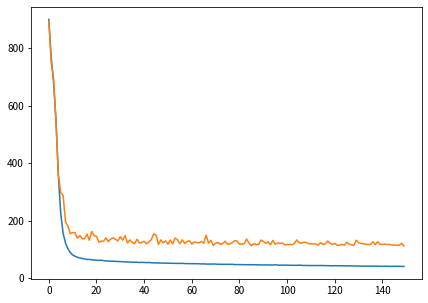

In [41]:
fig, ax = plt.subplots(figsize=(7,5))
ax.plot(range(len(trainer.train_losses)), trainer.train_losses)
ax.plot(range(len(trainer.val_losses)), trainer.val_losses)
plt.show()

In [430]:
print(trainer.validate(train_loader))
print(trainer.validate(val_loader))

78.99893493652344
109.23197791689918


## 予測結果

In [227]:
model_name = 'EncDec'

In [228]:
model = EncoderDecoder().to(device=device)
model.load_state_dict(torch.load(f'{config.MODEL_DIR}/{model_name}_77.pth'))
model.eval()

EncoderDecoder(
  (encoder): Encoder(
    (traffic_encoder): TrafficSearchEncoder(
      (conv): Conv2d(1, 64, kernel_size=(7, 5), stride=(1, 1), padding=(3, 0), padding_mode=replicate)
      (lstm): LSTM(64, 128, num_layers=2, batch_first=True, dropout=0.4, bidirectional=True)
    )
    (search_encoder): TrafficSearchEncoder(
      (conv): Conv2d(1, 64, kernel_size=(7, 5), stride=(1, 1), padding=(3, 0), padding_mode=replicate)
      (lstm): LSTM(64, 128, num_layers=2, batch_first=True, dropout=0.4, bidirectional=True)
    )
    (unspec_search_encoder): SearchUnspecEncoder(
      (conv): Conv1d(1, 64, kernel_size=(5,), stride=(1,), padding_mode=replicate)
      (dropout): Dropout(p=0.4, inplace=False)
    )
  )
  (decoder): Decoder(
    (traffic_decoder): TrafficDecoder(
      (lstm): LSTM(1, 256, num_layers=2, batch_first=True, dropout=0.3)
    )
    (affine_decoder): AffineDecoder(
      (datetime_embedding): CategoricalEmbedding(
        (embedding): Embedding(288, 32)
      )
     

In [229]:
def pred_data_generator(X_test, y_test, time_step, prediction_horizon=24):
    def create(zero_date, pred_start_date, pred_window, sec_id):
        pred_start_ind = int((pd.Timestamp(pred_start_date) - pd.Timestamp(zero_date)).total_seconds() / (60 * 60))
        pred_end_ind = pred_start_ind + pred_window

        in_start_ind = pred_start_ind - prediction_horizon - time_step + 1
        in_end_ind = pred_end_ind
        
        X_in = X_test[:, in_start_ind:in_end_ind, sec_id]
        y_in = y_test[:, in_start_ind:in_end_ind, sec_id]
        y_true = y_test[0, pred_start_ind:pred_end_ind, sec_id]
        
        return X_in, y_in, y_true
    return create

In [230]:
def predict(model, dataset, device=device):
    model.eval()

    with torch.no_grad():
        data, _ = dataset[:]
        if isinstance(data, (list, tuple)):
            data = map(lambda x: x.to(device=device), data)
        else:
            data = data.to(device=device)
        out = model.generate(data).detach().cpu()

    return out

In [231]:
p_gen = pred_data_generator(X_va, y_va, time_step=time_step)
zero_date = '2022/3/1'

In [232]:
pred_start_date = '2022/5/3'
pred_window = 1 * 24

X_in, y_in, y_true = p_gen(zero_date, pred_start_date, pred_window, sec_id=[34])
dataset_test = STDataset(X_in, y_in, time_step=time_step, space_window=space_window)

In [233]:
out = predict(model, dataset_test)
out = out.view(pred_window, -1)

In [234]:
print('mae', abs(y_true - out).mean().item())
print('mape', (abs(y_true - out) / y_true).mean().item())

mae 709.0714721679688
mape 0.36388394236564636


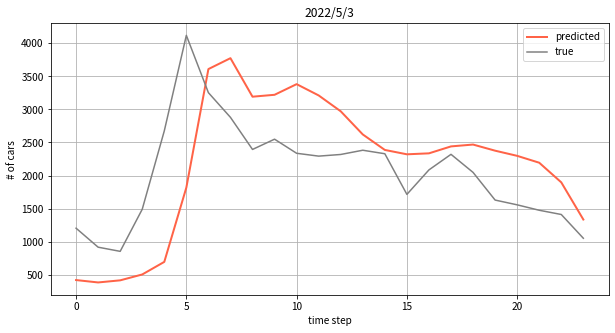

In [235]:
plt.figure(figsize=(10,5))
plt.plot(range(len(out)), out, label='predicted', color='tomato', lw=2)
plt.plot(range(len(y_true)), y_true, label='true', color='gray')
plt.xlabel('time step')
plt.ylabel('# of cars')
plt.title('2022/5/3')
plt.legend()
plt.grid()
plt.show()

In [236]:
pred_start_date = '2022/5/14'
pred_window = 1 * 24 

X_in, y_in, y_true = p_gen(zero_date, pred_start_date, pred_window, sec_id=[34])
dataset_test = STDataset(X_in, y_in, 
                         time_step=time_step,
                         space_window=space_window)

In [237]:
out = predict(model, dataset_test)
out = out.view(pred_window, -1)

In [238]:
print('mae', abs(y_true - out).mean().item())
print('mape', (abs(y_true - out) / y_true).mean().item())

mae 202.28700256347656
mape 0.15008196234703064


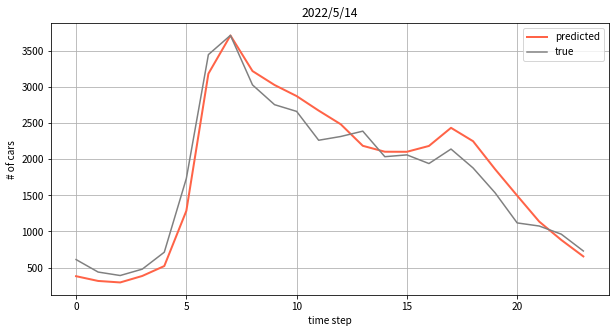

In [239]:
plt.figure(figsize=(10,5))
plt.plot(range(len(out)), out, label='predicted', color='tomato', lw=2)
plt.plot(range(len(y_true)), y_true, label='true', color='gray')
plt.xlabel('time step')
plt.ylabel('# of cars')
plt.title('2022/5/14')
plt.legend()
plt.grid()
plt.show()

In [240]:
pred_start_date = '2022/5/11'
pred_window = 1 * 24

X_in, y_in, y_true = p_gen(zero_date, pred_start_date, pred_window, sec_id=[34])
dataset_test = STDataset(X_in, y_in, 
                         time_step=time_step, 
                         space_window=space_window)

In [241]:
out = predict(model, dataset_test)
out = out.view(pred_window, -1)

In [242]:
print('mae', abs(y_true - out).mean().item())
print('mape', (abs(y_true - out) / y_true).mean().item())

mae 340.6014709472656
mape 0.21910633146762848


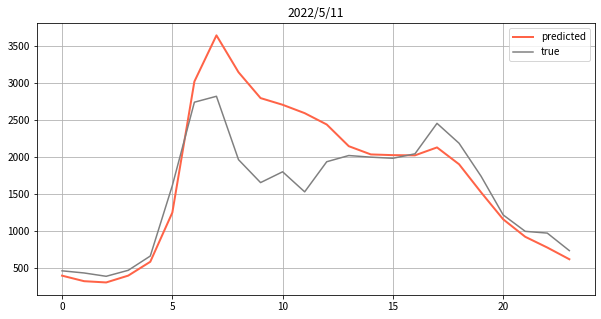

In [243]:
plt.figure(figsize=(10,5))
plt.plot(range(len(out)), out, label='predicted', color='tomato', lw=2)
plt.plot(range(len(y_true)), y_true, label='true', color='gray')
plt.title('2022/5/11')
plt.legend()
plt.grid()
plt.show()

### GW

In [244]:
pred_start_date = '2022/4/29'
pred_window = 9 * 24

X_in, y_in, y_true = p_gen(zero_date, pred_start_date, pred_window, sec_id=[34])
dataset_test = STDataset(X_in, y_in, 
                         time_step=time_step, 
                         space_window=space_window)

In [245]:
out = predict(model, dataset_test)
out = out.view(pred_window, -1)

In [246]:
print('mae', abs(y_true - out).mean().item())
print('mape', (abs(y_true - out) / y_true).mean().item())

mae 378.5409851074219
mape 0.20993874967098236


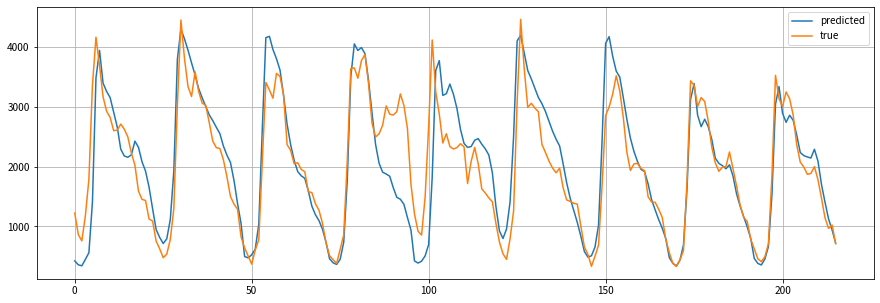

In [247]:
plt.figure(figsize=(15,5))
plt.plot(range(len(out)), out, label='predicted')
plt.plot(range(len(y_true)), y_true, label='true')
plt.legend()
plt.grid()
plt.show()

### 普通の1週間 (月~日)

#### 3月

In [112]:
pred_start_date = '2022/3/21'
pred_window = 7 * 24

X_in, y_in, y_true = p_gen(zero_date, pred_start_date, pred_window, sec_id=[34])
dataset_test = STDataset(X_in, y_in, 
                         time_step=time_step, 
                         space_window=space_window)

In [113]:
out = predict(model, dataset_test)
out = out.view(pred_window, -1)

In [114]:
print('mae', abs(y_true - out).mean().item())
print('mape', (abs(y_true - out) / y_true).mean().item())

mae 274.508056640625
mape 0.16060082614421844


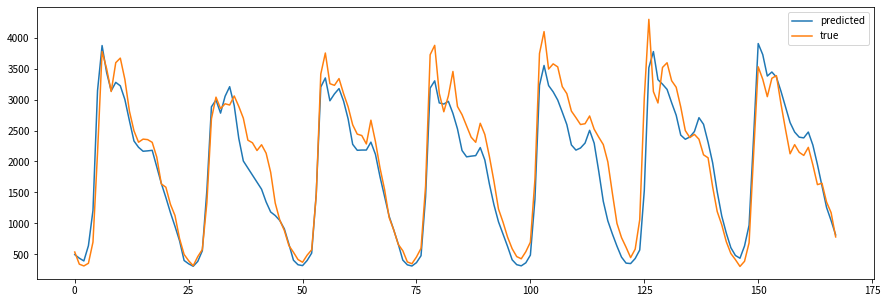

In [115]:
plt.figure(figsize=(15,5))
plt.plot(range(len(out)), out, label='predicted')
plt.plot(range(len(y_true)), y_true, label='true')
plt.legend()
plt.show()

#### 4月

In [116]:
pred_start_date = '2022/4/4'
pred_window = 7 * 24

X_in, y_in, y_true = p_gen(zero_date, pred_start_date, pred_window, sec_id=[27])
dataset_test = STDataset(X_in, y_in, 
                         time_step=time_step, 
                         space_window=space_window)

In [117]:
out = predict(model, dataset_test)
out = out.view(pred_window, -1)

In [118]:
print('mae', abs(y_true - out).mean().item())
print('mape', (abs(y_true - out) / y_true).mean().item())

mae 252.14720153808594
mape 0.15536610782146454


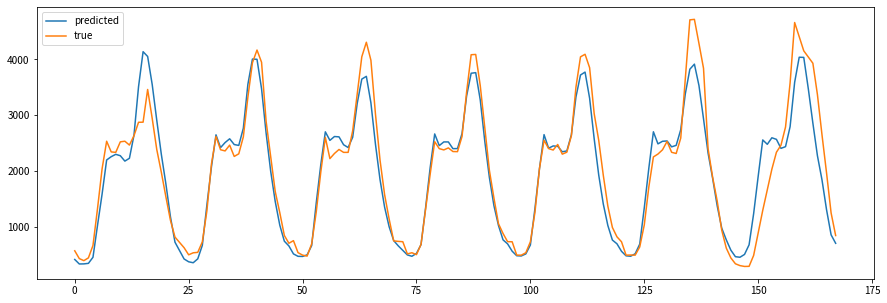

In [120]:
plt.figure(figsize=(15,5))
plt.plot(range(len(out)), out, label='predicted')
plt.plot(range(len(y_true)), y_true, label='true')
plt.legend()
plt.show()

#### 5月

In [121]:
pred_start_date = '2022/5/23'
pred_window = 7 * 24

X_in, y_in, y_true = p_gen(zero_date, pred_start_date, pred_window, sec_id=[27])
dataset_test = STDataset(X_in, y_in, 
                         time_step=time_step,
                         space_window=space_window)

In [122]:
out = predict(model, dataset_test)
out = out.view(pred_window, -1)

In [123]:
print('mae', abs(y_true - out).mean().item())
print('mape', (abs(y_true - out) / y_true).mean().item())

mae 267.24688720703125
mape 0.15511812269687653


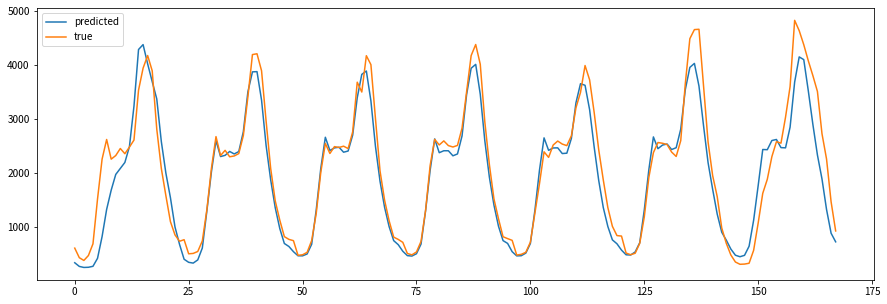

In [124]:
plt.figure(figsize=(15,5))
plt.plot(range(len(out)), out, label='predicted')
plt.plot(range(len(y_true)), y_true, label='true')
plt.legend()
plt.show()